## Mistral OCR

### Imports

In [30]:
import os
import json
import base64
from pathlib import Path
from IPython.display import Markdown, display
from enum import Enum
from pydantic import BaseModel
from PIL import Image

from mistralai import Mistral
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
from mistralai.models import OCRResponse

# Set the module directory to locate the .env file
base_directory = os.path.dirname(os.path.abspath("__file__"))

# Load environment variables from the .env file
from dotenv import load_dotenv
load_dotenv(os.path.join(base_directory, ".env"), override=True)

True

### Authentication

In [3]:
api_key = os.getenv("MISTRAL_API_KEY")
client = Mistral(api_key=api_key)

### OCR in a local file

Public example downloaded from [here](https://www.microsoft.com/investor/reports/ar24/download-center/?msockid=2034df9c5fe46ffa24f6cb2a5e836e8e) in docx fomart (converted to PDF). Also possible to use a URL as input

In [ ]:
# Reference the local file
pdf_file = Path(os.path.join("docs", "2024_Annual_Report.pdf"))

In [ ]:
# Upload for inference
uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)


In [ ]:
# Get the OCR output
signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)
pdf_response = client.ocr.process(document=DocumentURLChunk(document_url=signed_url.url), model="mistral-ocr-latest", include_image_base64=True)

{
    "pages": [
        {
            "index": 0,
            "markdown": "![img-0.jpeg](img-0.jpeg)\n\nMicrosoft\nAnnual Report 2024",
            "images": [
                {
                    "id": "img-0.jpeg",
                    "top_left_x": 183,
                    "top_left_y": 288,
                    "bottom_right_x": 1407,
                    "bottom_right_y": 1379,
                    "image_base64": ""
                }
            ],
            "dimensions": {
                "dpi": 200,
                "height": 2200,
                "width": 1700
            }
        },
        {
            "index": 1,
            "markdown": "Dear shareholders, colleagues, customers, and partners:\nFiscal year 2024 was a pivotal year for Microsoft. We entered our 50th year as a company and the second year of the AI platform shift. With these milestones, I've found myself reflecting on how Microsoft has remained a consequential company decade after decade in an industry with no 
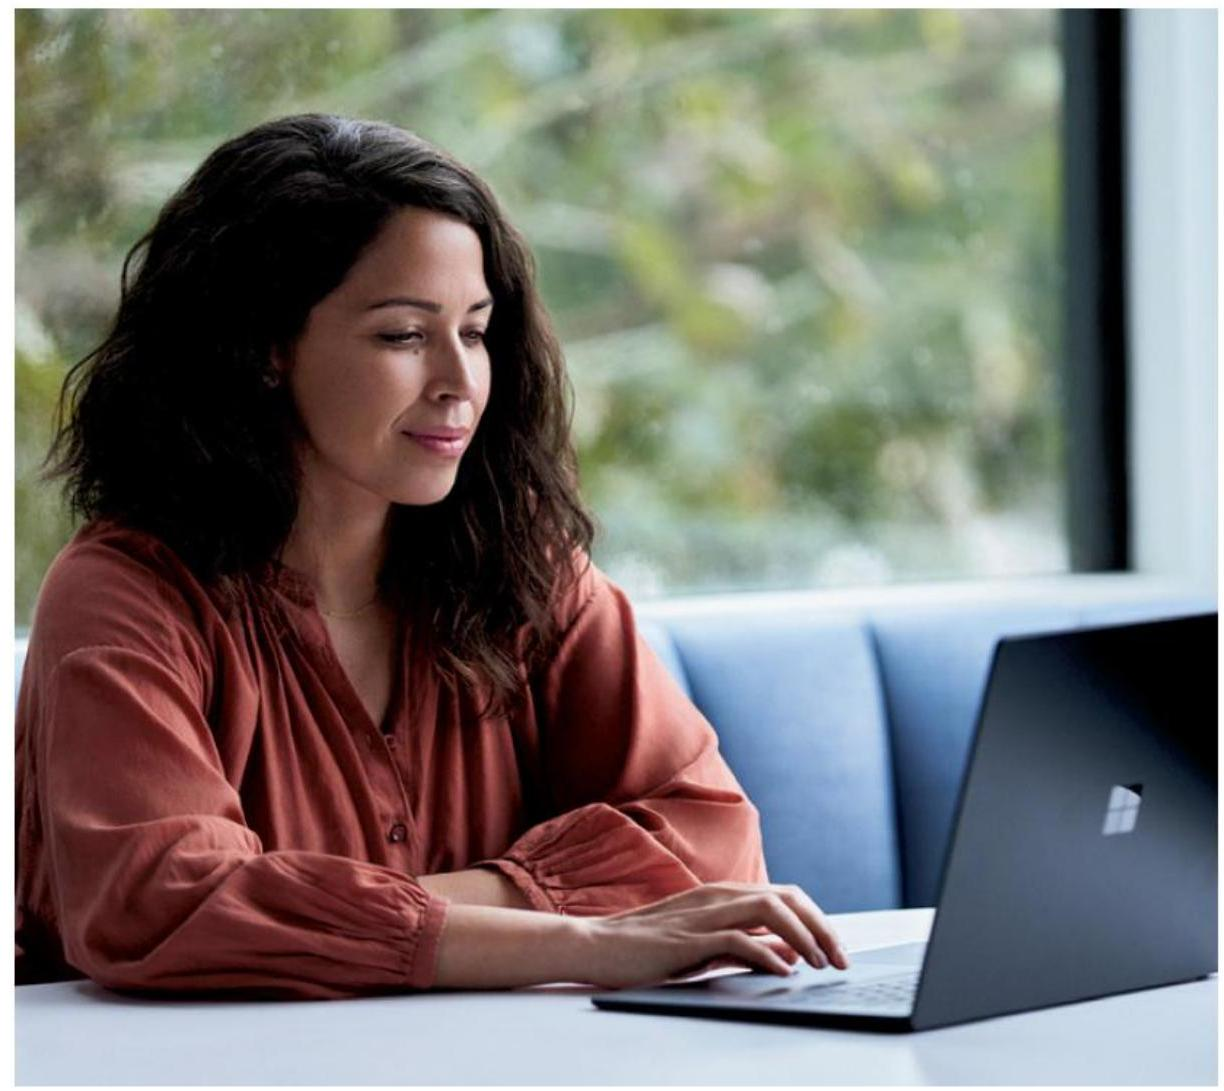
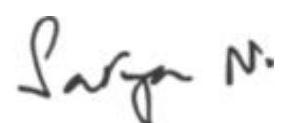
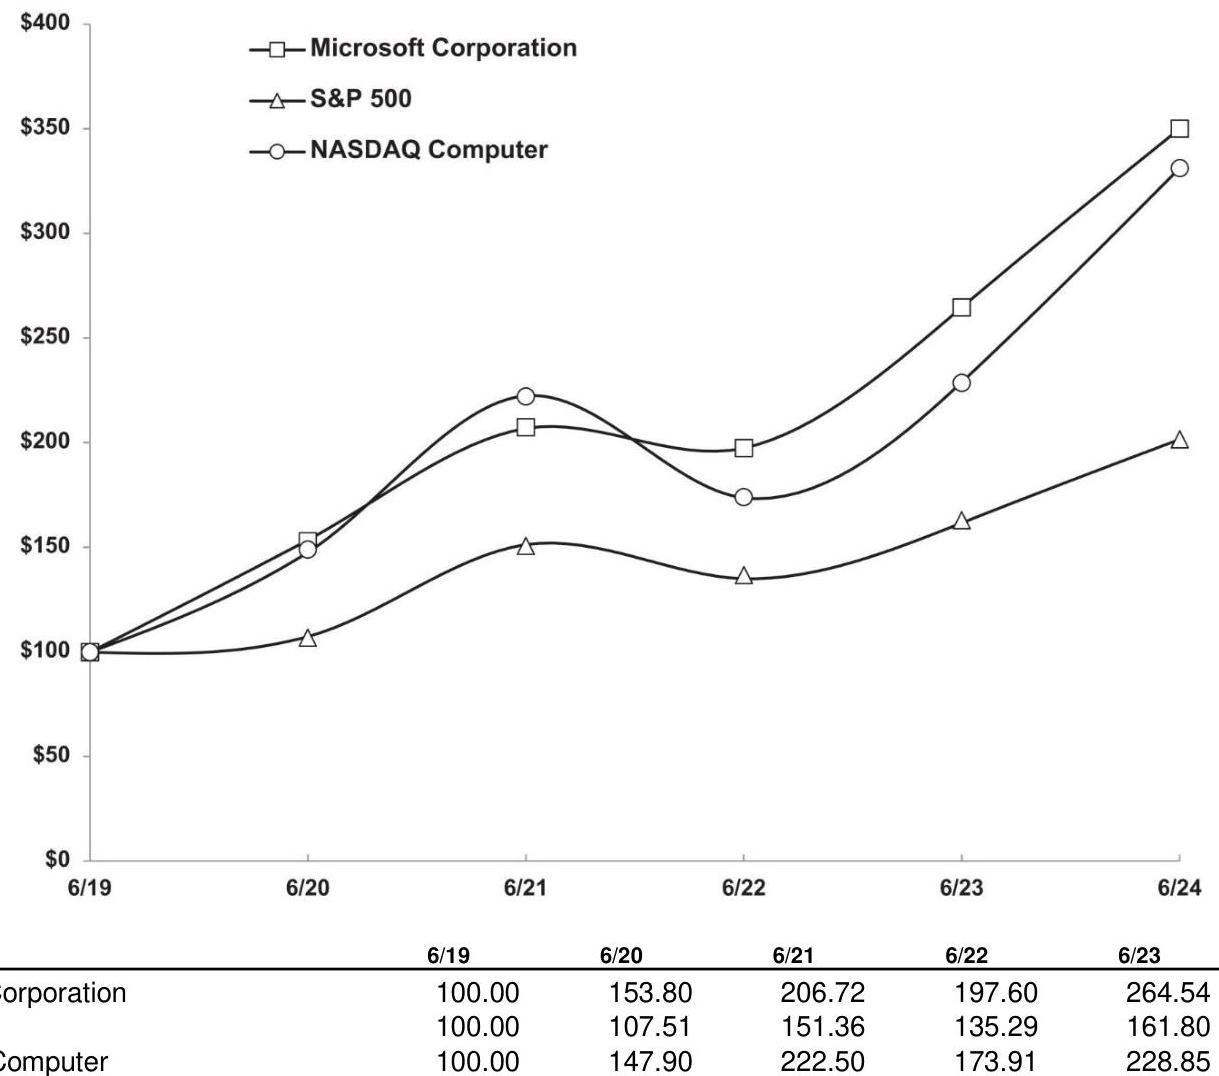
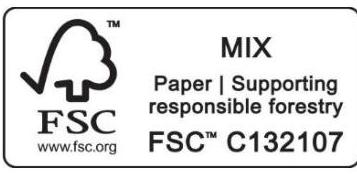

C:\Users\dalabbe\AppData\Local\Temp\ipykernel_2768\3197323659.py:2: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response_dict = json.loads(pdf_response.json())


In [16]:
# Explore the raw json output
response_dict = json.loads(pdf_response.json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

In [19]:
# helper functions
def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})")
    return markdown_str

def get_combined_markdown(ocr_response: OCRResponse) -> str:
  markdowns: list[str] = []
  for page in ocr_response.pages:
    image_data = {}
    for img in page.images:
      image_data[img.id] = img.image_base64
    markdowns.append(replace_images_in_markdown(page.markdown, image_data))

  return "\n\n".join(markdowns)

In [24]:
# Transform the result in the hierarchical md structure
md_content = get_combined_markdown(pdf_response)

In [ ]:
# display the markdown content on the notebook
# display(Markdown(md_content))

In [23]:
# Save the markdown content to a file
with open(os.path.join("outputs", "ocr_output.md"), "w") as f:
    f.write(md_content)

### Other Modalities - Image

In [26]:
# define a local file
image_file = Path(os.path.join("docs", "receipt.png"))

In [27]:
# prepare data for inference
encoded = base64.b64encode(image_file.read_bytes()).decode()
base64_data_url = f"data:image/jpeg;base64,{encoded}"

# run inference
image_response = client.ocr.process(document=ImageURLChunk(image_url=base64_data_url), model="mistral-ocr-latest")

# Explore the raw json output
response_dict = json.loads(image_response.json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "pages": [
        {
            "index": 0,
            "markdown": "# PLACE FACE UP ON DASH <br> CITY OF PALO ALTO <br> NOT VALID FOR ONSTREET PARKING \n\nExpiration Date/Time 11:59 PM\n\nAUG 19, 2024\n\nPurchase Date/Time: 01:34pm Aug 19, 2024\nTotal Due: $\\$ 15.00$\nRate: Daily Parking\nTotal Paid: $\\$ 15.00$\nPmt Type: CC (Swipe)\nTicket \\#: 00005883\nS/N \\#: 520117260957\nSetting: Permit Machines\nMach Name: Civic Center\n\\#^^^^-1224, Visa\nDISPLAY FACE UP ON DASH\n\nPERMIT EXPIRES\nAT MIDNIGHT",
            "images": [],
            "dimensions": {
                "dpi": 200,
                "height": 3210,
                "width": 1806
            }
        }
    ],
    "model": "mistral-ocr-2503-completion",
    "usage_info": {
        "pages_processed": 1,
        "doc_size_bytes": 3110191
    }
}


C:\Users\dalabbe\AppData\Local\Temp\ipykernel_2768\3477514224.py:9: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response_dict = json.loads(image_response.json())


### Run image + text prompts as input

Using `pixtral-12b-latest` and previous results `mistral-ocr-latest`

In [9]:
image_ocr_markdown = image_response.pages[0].markdown

chat_response = client.chat.complete(
    model="pixtral-12b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                ImageURLChunk(image_url=base64_data_url),
                TextChunk(text=f"This is image's OCR in markdown:\n<BEGIN_IMAGE_OCR>\n{image_ocr_markdown}\n<END_IMAGE_OCR>.\nConvert this into a sensible structured json response. The output should be strictly be json with no extra commentary")
            ],
        },
    ],
    response_format =  {"type": "json_object"},
    temperature=0
)

response_dict = json.loads(chat_response.choices[0].message.content)
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "parking_receipt": {
        "header": {
            "instructions": "PLACE FACE UP ON DASH",
            "city": "CITY OF PALO ALTO",
            "validity": "NOT VALID FOR ONSTREET PARKING"
        },
        "expiration": {
            "date_time": "11:59 PM",
            "date": "AUG 19, 2024"
        },
        "purchase": {
            "date_time": "01:34pm Aug 19, 2024"
        },
        "payment": {
            "total_due": "$15.00",
            "rate": "Daily Parking",
            "total_paid": "$15.00",
            "payment_type": "CC (Swipe)"
        },
        "details": {
            "ticket_number": "00005883",
            "serial_number": "520117260957",
            "setting": "Permit Machines",
            "machine_name": "Civic Center"
        },
        "footer": {
            "card_number": "#^^^^-1224",
            "card_type": "Visa",
            "instructions": "DISPLAY FACE UP ON DASH",
            "expiration_reminder": "PERMIT EXPIRES AT MIDNIGHT"
      

### Strucured Outputs

In [31]:
class StructuredOCR(BaseModel):
    file_name: str
    topics: list[str]
    ocr_contents: dict

def structured_ocr(image_path: str) -> StructuredOCR:
    image_file = Path(image_path)
    assert image_file.is_file(), "The provided image path does not exist."

    # Read and encode the image file
    encoded_image = base64.b64encode(image_file.read_bytes()).decode()
    base64_data_url = f"data:image/jpeg;base64,{encoded_image}"

    # Process the image using OCR
    image_response = client.ocr.process(document=ImageURLChunk(image_url=base64_data_url), model="mistral-ocr-latest")
    image_ocr_markdown = image_response.pages[0].markdown

    # Parse the OCR result into a structured JSON response
    chat_response = client.chat.parse(
        model="pixtral-12b-latest",
        messages=[
            {
                "role": "user",
                "content": [
                    ImageURLChunk(image_url=base64_data_url),
                    TextChunk(text=(
                        "This is the image's OCR in markdown:\n"
                        f"<BEGIN_IMAGE_OCR>\n{image_ocr_markdown}\n<END_IMAGE_OCR>.\n"
                        "Convert this into a structured JSON response with the OCR contents in a sensible dictionnary."
                    ))
                ],
            },
        ],
        response_format=StructuredOCR,
        temperature=0
    )

    return chat_response.choices[0].message.parsed

In [ ]:
# run the inference
image_path = os.path.join("docs", "receipt.png")
structured_response = structured_ocr(image_path)

response_dict = json.loads(structured_response.json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "file_name": "parking_receipt",
    "topics": [
        "Parking",
        "Receipt",
        "Payment",
        "Expiration"
    ],
    "ocr_contents": {
        "header": "PLACE FACE UP ON DASH",
        "city": "CITY OF PALO ALTO",
        "validity": "NOT VALID FOR ONSTREET PARKING",
        "expiration": {
            "date": "AUG 19, 2024",
            "time": "11:59 PM"
        },
        "purchase": {
            "date": "Aug 19, 2024",
            "time": "01:34pm"
        },
        "total_due": "$15.00",
        "rate": "Daily Parking",
        "total_paid": "$15.00",
        "payment_type": "CC (Swipe)",
        "ticket_number": "00005883",
        "serial_number": "520117260957",
        "setting": "Permit Machines",
        "machine_name": "Civic Center",
        "card_info": "#^^^^-1224, Visa",
        "instructions": "DISPLAY FACE UP ON DASH",
        "expiry_message": "PERMIT EXPIRES AT MIDNIGHT"
    }
}


C:\Users\dalabbe\AppData\Local\Temp\ipykernel_2768\3146635834.py:4: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response_dict = json.loads(structured_response.json())


The original image for comparison can be found below.

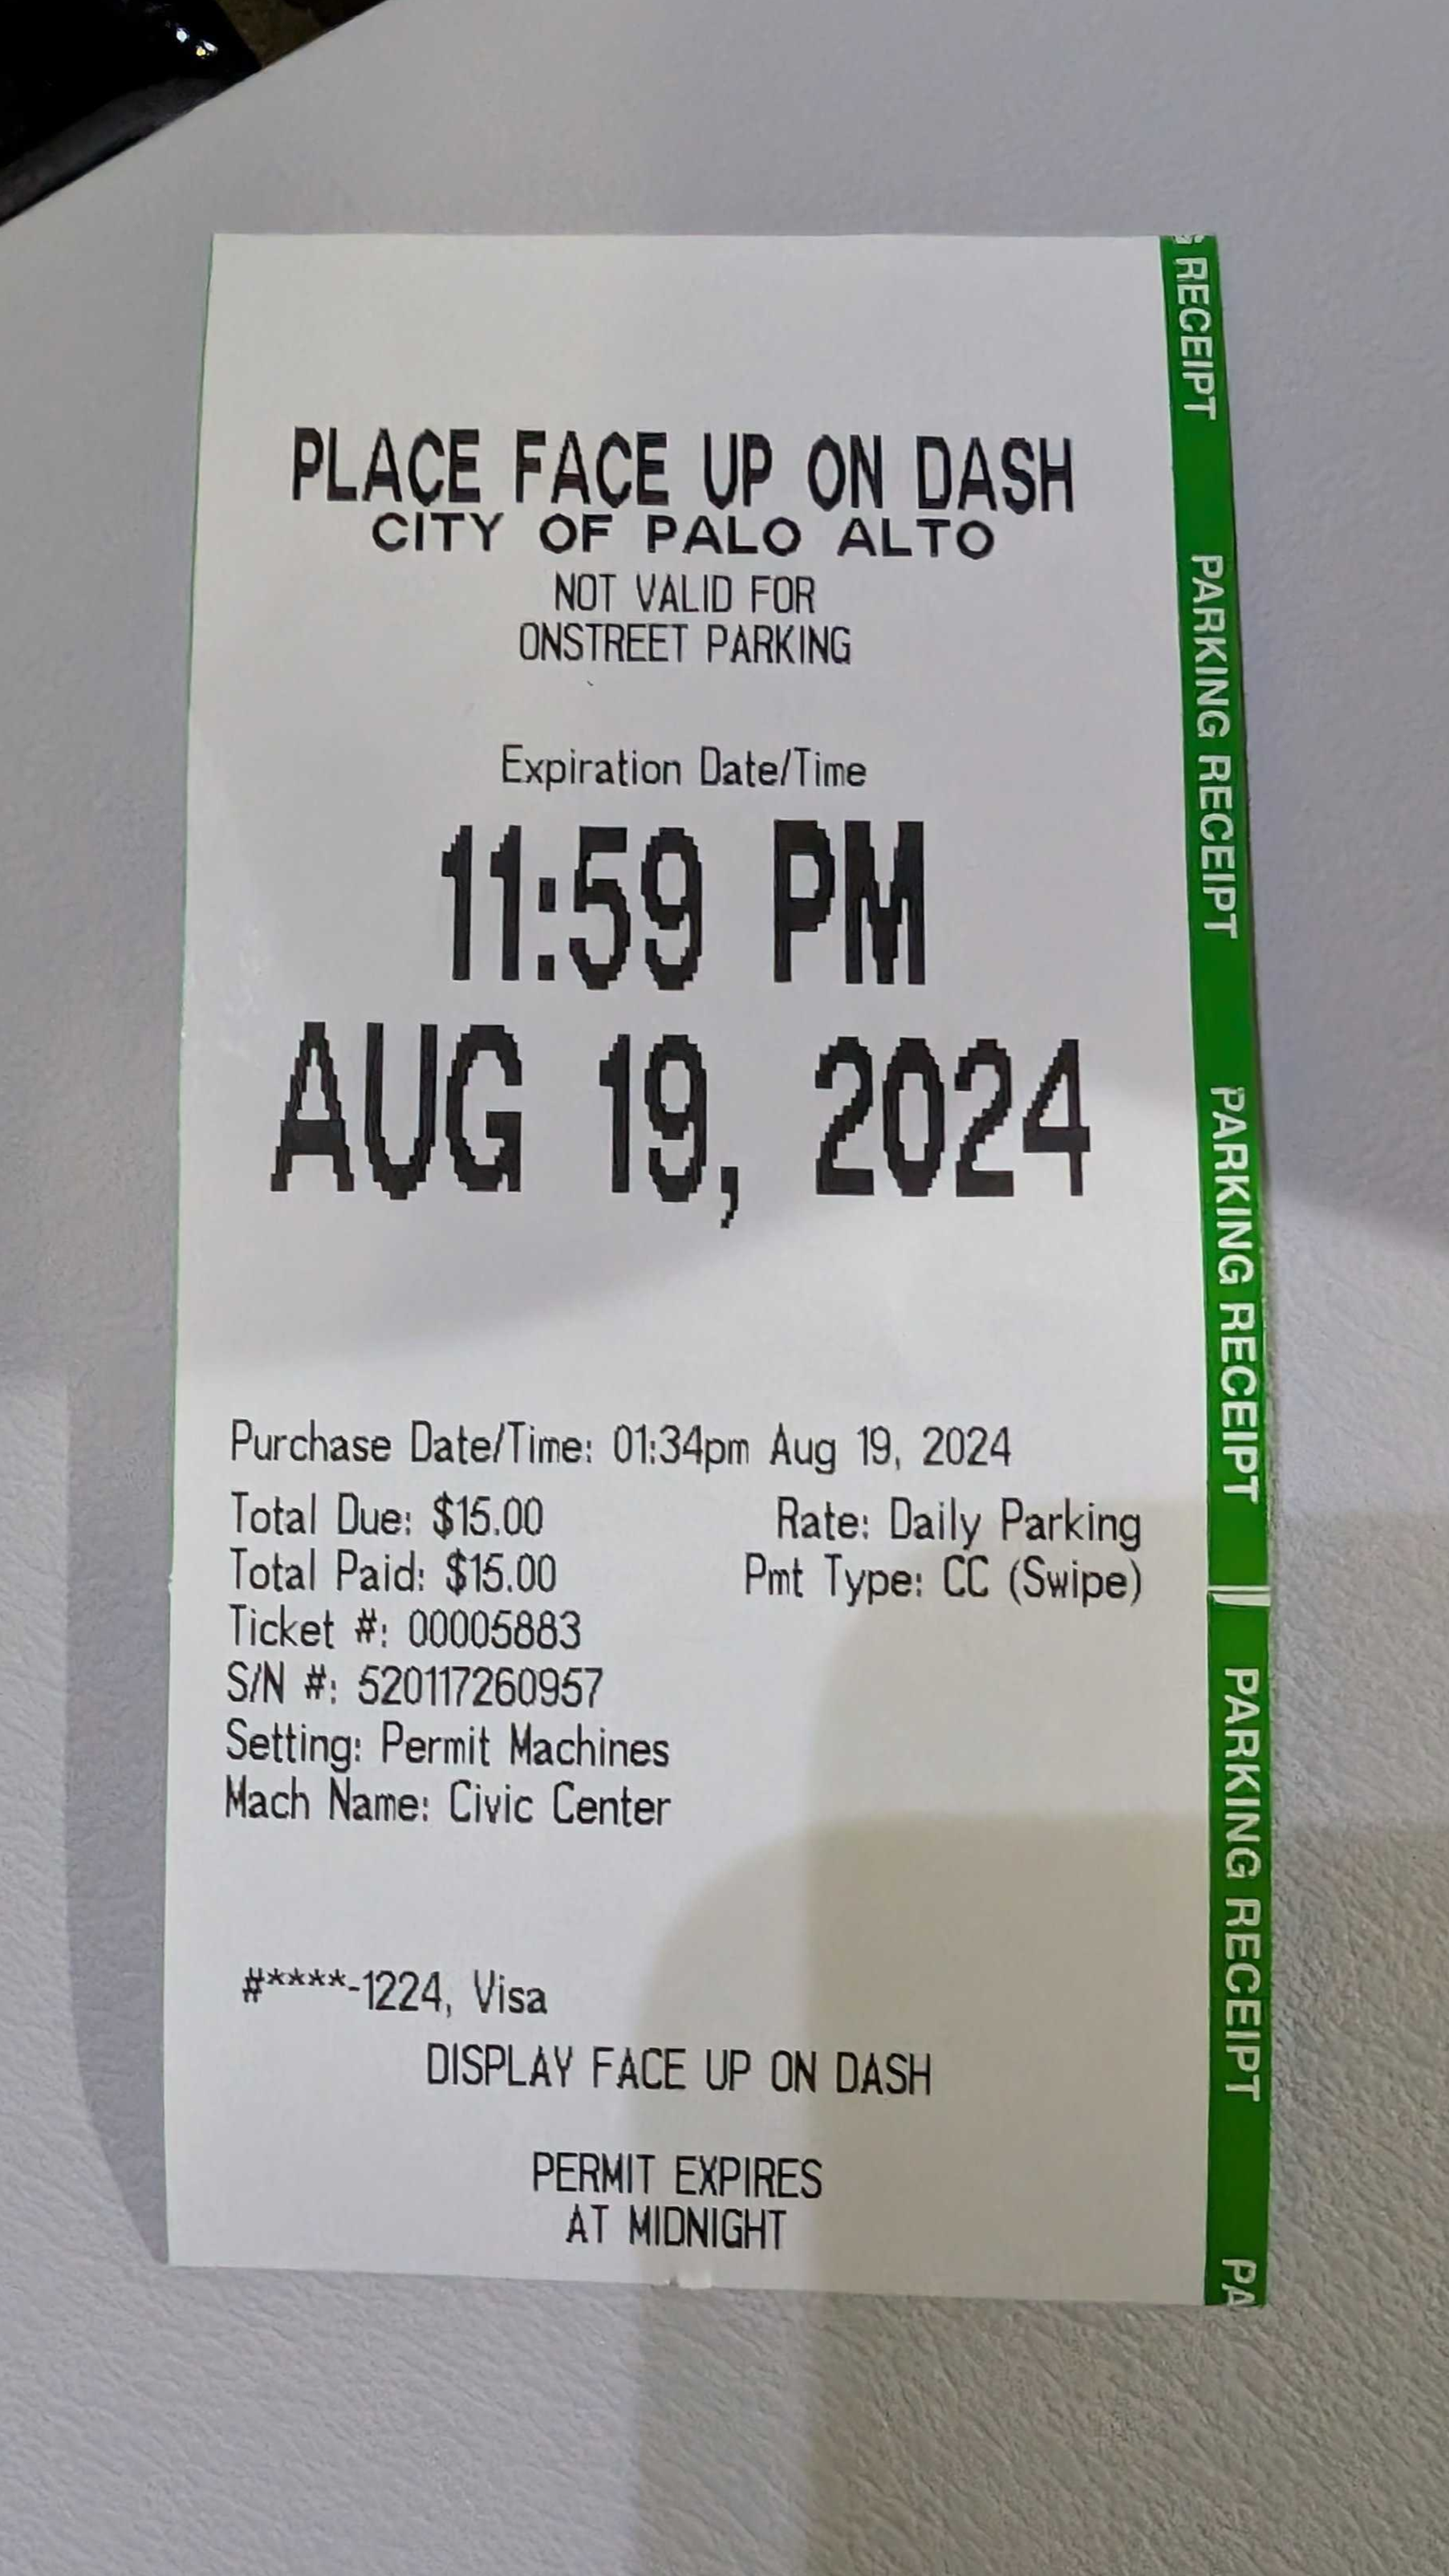

In [33]:
image = Image.open(image_path)
image